In [332]:
from queue import Queue
import numpy as np
import sys
from __future__ import division
import cv2
import os
from math import exp, pow
from PIL import Image, ImageOps
import matplotlib.pyplot as plt

In [333]:
def bfs(rGraph, V, s, t, parent):
    q = Queue()
    visited = np.zeros(V, dtype=bool)
    q.put(s)
    visited[s] = True
    parent[s]  = -1

    while not q.empty():
        u = q.get()
        for v in range(V):
            if (not visited[v]) and rGraph[u][v] > 0:
                q.put(v)
                parent[v] = u
                visited[v] = True
    return visited[v]

def dfs(rGraph, V, s, visited):
  stack = [s]
  while stack:
    v = stack.pop()
    if not visited[v]:
      visited[v] = True
      stack.extend([u for u in range(V) if rGraph[v][u]])



def augmentingPath(graph, s, t):
    print("Running augmenting path algorithm")
    rGraph = graph.copy()
    V = len(graph)
    parent = np.zeros(V, dtype='int32')

    while bfs(rGraph, V, s, t, parent):
        pathFlow = float("inf")
        v = t
        while v != s:
            u = parent[v]
            pathFlow = min(pathFlow, rGraph[u][v])
            v = parent[v]

        v = t
        while v != s:
            u = parent[v]
            rGraph[u][v] -= pathFlow
            rGraph[v][u] += pathFlow
            v = parent[v]

    visited = np.zeros(V, dtype=bool)
    dfs(rGraph, V, s, visited)

    cuts = []

    for i in range(V):
        for j in range(V):
            if visited[i] and not visited[j] and graph[i][j]:
                cuts.append((i, j))
    return cuts

In [335]:
SIGMA = 30
OBJCODE, BKGCODE = 1, 2
CUTCOLOR = (0, 0, 255)

# Large when ip - iq < sigma, and small otherwise
def boundaryPenalty(ip, iq):
    bp = 100 * exp(- pow(int(ip) - int(iq), 2) / (2 * pow(SIGMA, 2)))
    return bp

def buildGraph(image):
    V = image.size + 2
    graph = np.zeros((V, V), dtype='int32')
    K = makeNLinks(graph, image)
    seeds, seededImage = plantSeed(image)
    makeTLinks(graph, seeds, K)
    return graph, seededImage

def makeNLinks(graph, image):
    K = -float("inf")
    r, c = image.shape
    for i in range(r):
        for j in range(c):
            x = i * c + j
            if i + 1 < r: # pixel below
                y = (i + 1) * c + j
                bp = boundaryPenalty(image[i][j], image[i + 1][j])
                graph[x][y] = graph[y][x] = bp
                K = max(K, bp)
            if j + 1 < c: # pixel to the right
                y = i * c + j + 1
                bp = boundaryPenalty(image[i][j], image[i][j + 1])
                graph[x][y] = graph[y][x] = bp
                K = max(K, bp)
    return K



def makeTLinks(graph, seeds, K):
    r, c = seeds.shape

    for i in range(r):
        for j in range(c):
            x = i * c + j
            if seeds[i][j] == OBJCODE:
                graph[SOURCE][x] = K
            elif seeds[i][j] == BKGCODE:
                graph[x][SINK] = K
                
def displayCut(image, cuts):
    def colorPixel(i, j):
        image[i][j] = CUTCOLOR

    r, c = image.shape
    image = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)
    for c in cuts:
        if c[0] != SOURCE and c[0] != SINK and c[1] != SOURCE and c[1] != SINK:
            colorPixel(c[0] // r, c[0] % r)
            colorPixel(c[1] // r, c[1] % r)
    return image

In [473]:
SOURCE, SINK = -2, -1
SIZE = 45
#pathname = os.path.splitext(imagefile)[0]
image = cv2.imread('./sample_data/original.png', cv2.IMREAD_GRAYSCALE)
image = cv2.resize(image, (SIZE, SIZE))

In [474]:
image.shape

(45, 45)

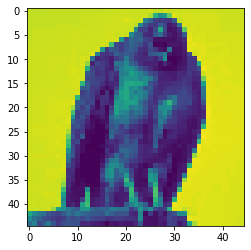

In [475]:
plt.imshow(image)

In [476]:
seededImage = cv2.imread('./sample_data/onlySeeds3.png')
seededImage = cv2.resize(seededImage, (SIZE, SIZE))

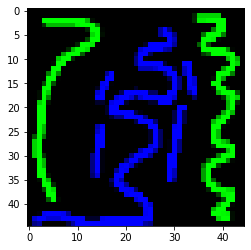

In [478]:
plt.imshow(seededImage)

In [479]:
seeds = np.zeros(image.shape, dtype="uint8")

In [480]:
for x in range(seededImage.shape[0]):
  for y in range(seededImage.shape[1]):
    pixel = np.array2string(seededImage[x, y])
    
    if (pixel == '[  0   0 255]'):      # FOREGROUND
      seeds[x, y] = 1
    elif (pixel == '[  0 255   0]'):    # BACKGROUND
      seeds[x, y] = 2

In [481]:
seeds.shape

(45, 45)

# interactive colab
https://colab.research.google.com/notebooks/snippets/advanced_outputs.ipynb#scrollTo=iU_0F2SVW4Yb

In [482]:
V = image.size + 2
graph = np.zeros((V, V), dtype='int32')
K = makeNLinks(graph, image)
makeTLinks(graph, seeds, K)

SOURCE += len(graph) 
SINK   += len(graph)

cuts = augmentingPath(graph, SOURCE, SINK)
#cuts = pushRelabel(graph, SOURCE, SINK)
cuttedImaged = displayCut(image, cuts)

Running augmenting path algorithm


In [483]:
cuts

[(116, 71),
 (117, 72),
 (118, 73),
 (158, 157),
 (202, 157),
 (202, 201),
 (246, 201),
 (246, 245),
 (289, 244),
 (289, 288),
 (375, 330),
 (375, 374),
 (377, 332),
 (529, 530),
 (553, 552),
 (575, 530),
 (597, 552),
 (687, 686),
 (711, 666),
 (711, 712),
 (731, 686),
 (821, 820),
 (865, 820),
 (1000, 999),
 (1044, 999),
 (1071, 1116),
 (1205, 1250),
 (1269, 1268),
 (1313, 1268),
 (1313, 1312),
 (1339, 1384),
 (1562, 1607),
 (1651, 1696),
 (1717, 1672),
 (1717, 1716),
 (1740, 1785),
 (1762, 1761),
 (1807, 1806),
 (1851, 1806),
 (1851, 1850),
 (1873, 1874),
 (1890, 1845),
 (1891, 1846),
 (1919, 1874),
 (1922, 1877),
 (1922, 1923),
 (2012, 2013)]

In [484]:
cuttedImaged.shape

(45, 45, 3)

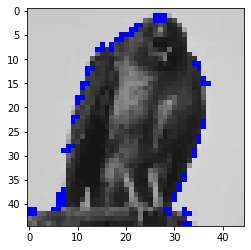

In [485]:
plt.imshow(cuttedImaged)

TODO
* improve performance 45x45 image takes 5 minutes to process
* add frontend
* review https://github.com/mjirik/imcut (reshape 2d image into 3d) (if possible, then discard scratch implementation)